## Requirements
- Download the dataset from Kaggle.
- Query the dataset using sqlite. Only load the final dataset into a dataframe.
- Give an overview of the respondents of the survey. What is the sample size? What are the sociodemographic features of the respondents? Do you see any evidence of sampling bias?
- Perform exploratory data analysis. This should include creating statistical summaries and charts, checking for correlations and other relationships between variables, as well as other EDA elements.
- In a plot, report the prevalence rate of at least three mental diseases. Make sure to plot the confidence interval and provide its interpretation.
- Your notebook should be readable as a standalone document. In Markdown cells inform the reader of the questions you are trying to answer, and provide an interpretation of your results.
- Provide suggestions about how your analysis can be improved.

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import sqlite3

# creating file path
dbfile = 'mental_health.sqlite'
# Create a SQL connection to our SQLite database
con = sqlite3.connect(dbfile)

# creating cursor
cur = con.cursor()

# reading all table names
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
# here is you table list
print(table_list)

[('Answer',), ('Question',), ('Survey',)]


In [4]:
pd.set_option("display.max_columns", None)

In [5]:
pd.set_option("display.max_colwidth", None)

In [6]:
sns.set(rc = {'figure.figsize':(14,4)})

In [7]:
for table in table_list:
    table = table[0]
    req = 'SELECT * FROM ' + table
    tbl_response = cur.execute(req)
    df_name = f'df_{table}'.lower()
    globals()[df_name] = pd.DataFrame(tbl_response.fetchall())

Answer table: column 0 looks to be answer text, column 1 looks to be survey id (and survey year), column 2 looks to be an respondent id, column 3 looks to be a question id.

In [8]:
df_answer.rename(columns = {0:'ans', 1: 's_id', 2: 'r_id', 3:'q_id'}, inplace = True)

In [9]:
df_question.rename(columns = {0:'q', 1: 'id'}, inplace = True)

In [10]:
df_question.set_index('id', inplace = True)

In [11]:
df_survey.rename(columns = {0:'id', 1: 'Survey'}, inplace = True)

In [12]:
df_survey.set_index('id', inplace = True)

### Multiple answers for one question

In [13]:
ans_count_by_r_id_by_q_id = df_answer.groupby(['r_id', 'q_id'])['ans'].count()

In [14]:
ans_count_by_r_id_by_q_id[ans_count_by_r_id_by_q_id>1]

r_id  q_id
1262  115     2
      117     2
1264  115     2
1265  115     2
      117     7
             ..
2686  117     5
2688  115     3
2691  116     2
2692  115     3
2693  115     4
Name: ans, Length: 1190, dtype: int64

In [15]:
ans_count_by_r_id_by_q_id_indices = ans_count_by_r_id_by_q_id[ans_count_by_r_id_by_q_id>1].index

In [16]:
questions_with_multiple_answer = {index[1] for index in ans_count_by_r_id_by_q_id_indices}

In [17]:
questions_with_multiple_answer

{115, 116, 117}

In [18]:
respondents_with_multiple_answer = {index[0] for index in ans_count_by_r_id_by_q_id_indices}

In [19]:
len(respondents_with_multiple_answer)

924

Questions with multiple answers: 115, 116, 117
Number of respondents with multiple answers for a question: 924

In [20]:
df_question.loc[115:117]

,q
id,
115,"If yes, what condition(s) have you been diagnosed with?"
116,"If maybe, what condition(s) do you believe you have?"
117,Which of the following best describes your work position?


#### Combining multiple answer for a single question

In [21]:
df_answer_ans_combined = df_answer.groupby(['r_id', 'q_id'], as_index=False).agg({'ans': ' & '.join})

In [22]:
df_answer_ans_combined.shape

(234640, 3)

### Combining datasets ('answers' and 'questions') to one: df_all

In [23]:
df_all = df_answer_ans_combined.merge(right=df_question, left_on='q_id', right_on='id')

In [24]:
df_all.drop(columns='q_id', inplace=True)

In [25]:
df_all.shape

(234640, 3)

In [26]:
df_all = df_all.set_index(['r_id', 'q'])

In [27]:
df_all = df_all.unstack(level=-1)

In [28]:
df_all.columns = [col[1] for col in df_all.columns.values]

df_all - dataframe with all respondents as rows, all questions as columns and all answers as values. Multiple answers for a single question combined into one value.

## Analysis

### Question "Do you currently have a mental health disorder?"

In [29]:
df_all['Do you currently have a mental health disorder?'].value_counts(dropna=False)

Do you currently have a mental health disorder?
NaN           1260
Yes           1237
No             969
Maybe          327
Possibly       301
Don't Know     124
Name: count, dtype: int64

Let's merge answers 'Maybe', 'Possibly', "Don't Know"  into one.

In [30]:
df_all.loc[df_all['Do you currently have a mental health disorder?'].isin(['Maybe', 'Possibly', "Don't Know"]), 'Do you currently have a mental health disorder?'] = 'Maybe'

In [31]:
df_all.fillna({'Do you currently have a mental health disorder?': 'No answer'}, inplace=True)

In [32]:
df_all['Do you currently have a mental health disorder?'].value_counts(dropna=False)

Do you currently have a mental health disorder?
No answer    1260
Yes          1237
No            969
Maybe         752
Name: count, dtype: int64

<Axes: xlabel='Do you currently have a mental health disorder?', ylabel='count'>

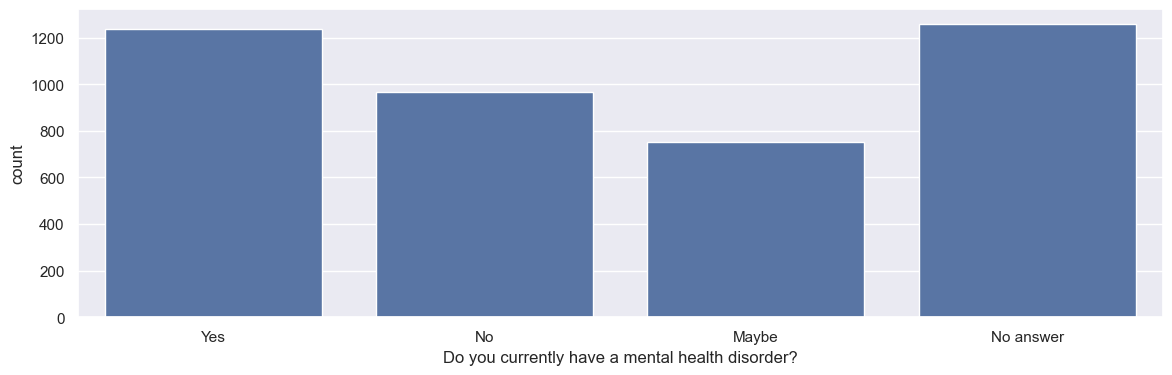

In [33]:
sns.countplot(x='Do you currently have a mental health disorder?', data=df_all, order=['Yes', 'No', 'Maybe', 'No answer'])

##### 'Mental health disorder' question by years

In [34]:
df_answer[df_answer['q_id']==33]['s_id'].value_counts()

s_id
2016    1433
2017     756
2018     417
2019     352
Name: count, dtype: int64

In [35]:
df_answer[df_answer['q_id']==33].groupby(['s_id', 'ans'])['ans'].count().unstack(level=0).fillna(0)

s_id,2016,2017,2018,2019
ans,,,,
Don't Know,0.0,66.0,32.0,26.0
Maybe,327.0,0.0,0.0,0.0
No,531.0,222.0,112.0,104.0
Possibly,0.0,144.0,82.0,75.0
Yes,575.0,324.0,191.0,147.0


<Axes: xlabel='s_id', ylabel='count'>

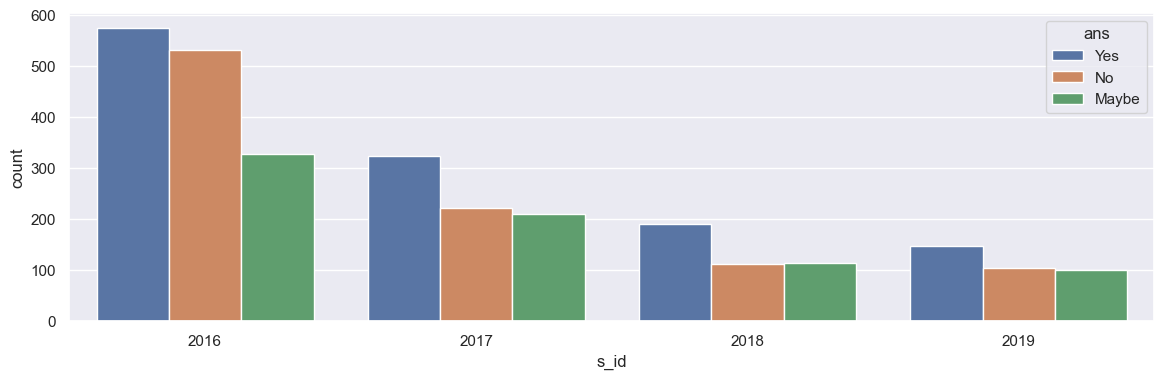

In [36]:
sns.countplot(data=df_answer[df_answer['q_id']==33].replace({'ans': {'Possibly': 'Maybe', "Don't Know": 'Maybe'}}), x='s_id', hue='ans', hue_order=['Yes', 'No', 'Maybe'])

Distributions for 'mental health disorder' question are similar for all the years in the survey, but andswers for the question were getting fewer from year to year.

### "What is your gender?" question

In [37]:
df_all["What is your gender?"].value_counts(dropna=False)

What is your gender?
Male                            2830
Female                           914
male                             212
female                           110
-1                                24
                                ... 
43                                 1
masculino                          1
I am a Wookie                      1
Trans non-binary/genderfluid       1
Non-binary and gender fluid        1
Name: count, Length: 101, dtype: int64

In [38]:
df_all["What is your gender?"].unique()

array(['Female', 'Male', 'Male-ish', 'Trans-female',
       'something kinda male?', 'queer/she/they', 'non-binary', 'Nah',
       'All', 'Enby', 'fluid', 'Genderqueer', 'Androgyne', 'Agender',
       'Guy (-ish) ^_^', 'male leaning androgynous', 'Trans woman',
       'Neuter', 'Female (trans)', 'queer', 'A little about you', 'p',
       'ostensibly male, unsure what that really means', 'Bigender',
       'Female assigned at birth', 'fm', 'Transitioned, M2F',
       'Genderfluid (born female)', 'Other/Transfeminine',
       'Female or Multi-Gender Femme', 'Androgynous',
       'male 9:1 female, roughly', '-1', 'Other', 'nb masculine',
       'none of your business', 'genderqueer', 'Human', 'Genderfluid',
       'genderqueer woman', 'mtf', 'Queer', 'Fluid', 'Male/genderqueer',
       'Nonbinary', 'human', 'Unicorn', 'Male (trans, FtM)',
       'Genderflux demi-girl', 'female-bodied; no feelings about gender',
       'AFAB', 'Transgender woman', 'male', 'female', 'male/androgynous',
    

In [39]:
df_all.replace({"What is your gender?": {'male': 'Male', 'female': 'Female'}}, inplace=True)

In [40]:
df_all.loc[~df_all["What is your gender?"].isin(['Male', 'Female']), "What is your gender?"]='Other'

In [41]:
df_all["What is your gender?"].value_counts(dropna=False)

What is your gender?
Male      3042
Female    1024
Other      152
Name: count, dtype: int64

<Axes: xlabel='What is your gender?', ylabel='count'>

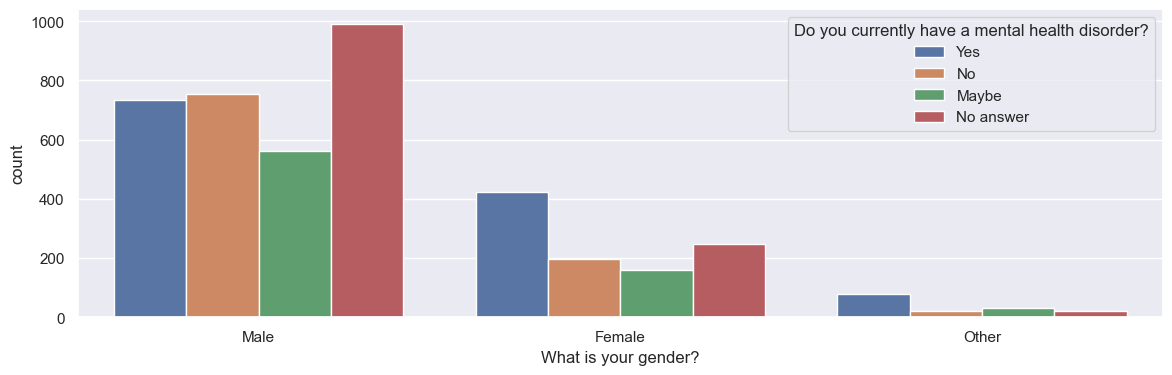

In [42]:
sns.countplot(x='What is your gender?', data=df_all, order = df_all['What is your gender?'].value_counts().index,
             hue='Do you currently have a mental health disorder?',
             hue_order=['Yes', 'No', 'Maybe', 'No answer'])

The graph shows answer distributions for "Do you currently have a mental health disorder?" question for males, females and other genders.

- Male: the most popular answer: 'No answer', then 'No', then 'Yes' and then 'Maybe'.
- Female: the most popular answer: 'Yes', then 'No answer', then 'No' and then 'Maybe'.
- Other genders: the most popular answer: 'Yes', then 'Maybe', then 'No answer' and then 'No'.

As 'male' to 'female' answers are 3:1. Let's create a graph to show relative difference.

In [43]:
male_mhd = df_all['Do you currently have a mental health disorder?'][df_all['What is your gender?']=='Male'].value_counts()

In [44]:
female_mhd = df_all['Do you currently have a mental health disorder?'][df_all['What is your gender?']=='Female'].value_counts()

In [45]:
other_mhd = df_all['Do you currently have a mental health disorder?'][df_all['What is your gender?']=='Other'].value_counts()

In [46]:
mhd_by_gender = pd.DataFrame([male_mhd/male_mhd.sum()*100, 
                              female_mhd/female_mhd.sum()*100, 
                              other_mhd/other_mhd.sum()*100], 
                             index=['Male', 'Female', 'Other'])

In [47]:
mhd_by_gender

Do you currently have a mental health disorder?,No answer,No,Yes,Maybe
Male,32.577252,24.786325,24.128863,18.507561
Female,24.121094,19.042969,41.406250,15.429688
Other,14.473684,13.157895,51.973684,20.394737


<Axes: >

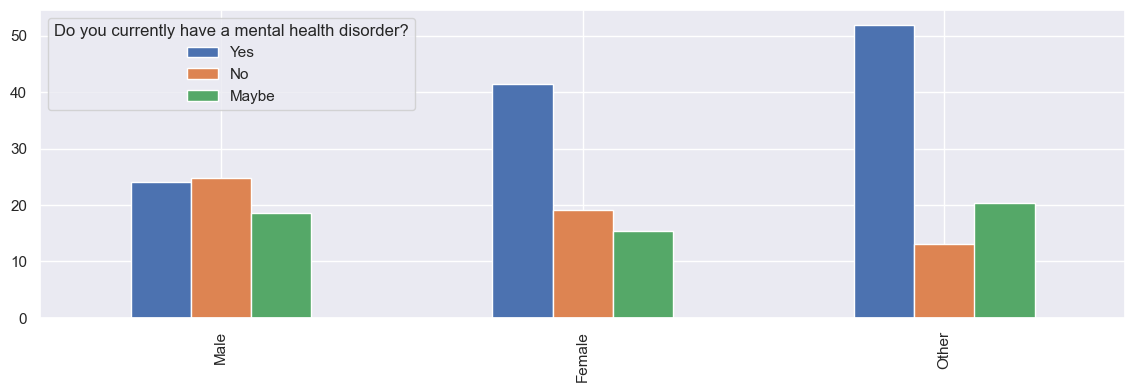

In [48]:
mhd_by_gender[['Yes', 'No', 'Maybe']].plot(kind = 'bar', label='sdfsdf')

- 52% respondents who is not in Male or Female gender claimed they have mental health disorder, and no disorder 13%.
- Next are females: 41% - disorder 'yes', 19% - 'no'.
- Males: 24% - 'yes', 25% - 'no'.

### Question "Are you openly identified at work as a person with a mental health issue?"

In [49]:
df_all['Are you openly identified at work as a person with a mental health issue?'].value_counts(dropna=False)

Are you openly identified at work as a person with a mental health issue?
NaN    2693
0      1340
1       183
-1        2
Name: count, dtype: int64

In [50]:
df_all.replace({'Are you openly identified at work as a person with a mental health issue?': {'0': 'No', '1': 'Yes', '-1': np.nan}}, inplace=True)

In [51]:
df_all[df_all['Are you openly identified at work as a person with a mental health issue?']=='Yes']['Do you currently have a mental health disorder?'].value_counts()

Do you currently have a mental health disorder?
Yes      153
Maybe     23
No         7
Name: count, dtype: int64

In [52]:
df_all[df_all['Do you currently have a mental health disorder?']=='Yes']['Are you openly identified at work as a person with a mental health issue?'].value_counts()

Are you openly identified at work as a person with a mental health issue?
No     507
Yes    153
Name: count, dtype: int64

<Axes: xlabel='Are you openly identified at work as a person with a mental health issue?', ylabel='count'>

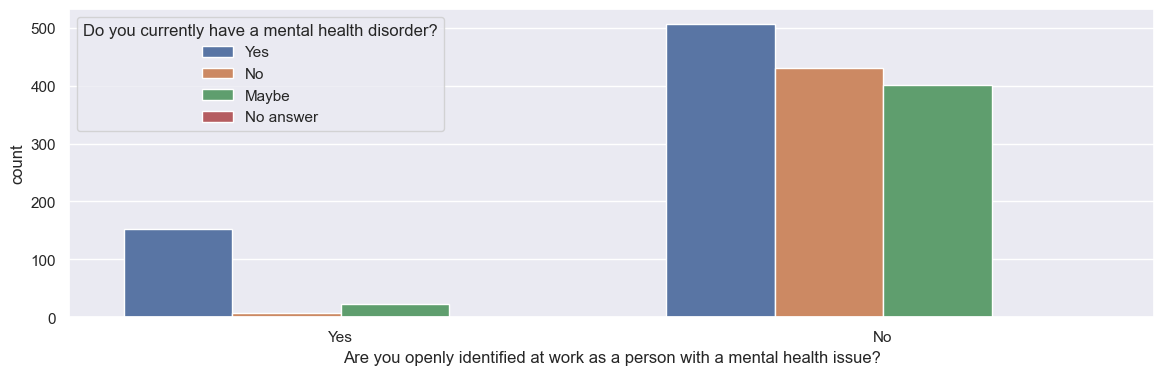

In [53]:
sns.countplot(df_all, x='Are you openly identified at work as a person with a mental health issue?', hue='Do you currently have a mental health disorder?', 
              hue_order=['Yes', 'No', 'Maybe', 'No answer'], order=['Yes', 'No'])

<Axes: xlabel='Do you currently have a mental health disorder?', ylabel='count'>

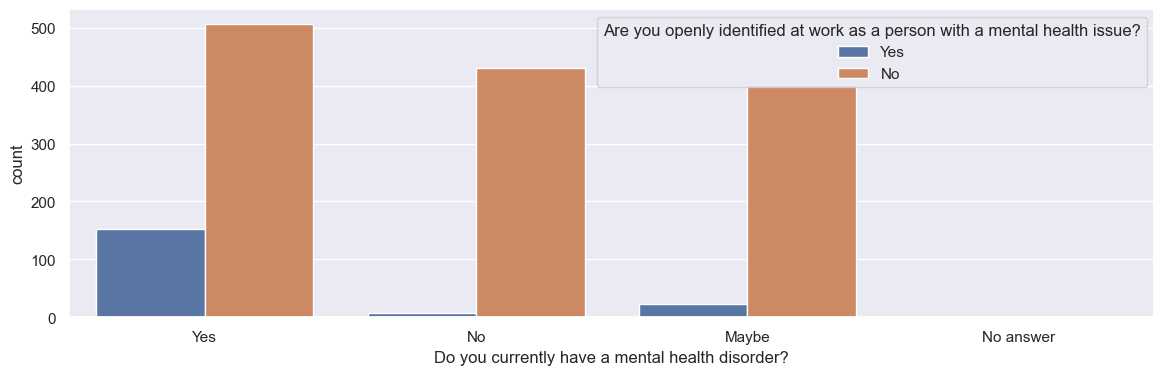

In [54]:
sns.countplot(df_all, hue='Are you openly identified at work as a person with a mental health issue?', x='Do you currently have a mental health disorder?', 
              order=['Yes', 'No', 'Maybe', 'No answer'], hue_order=['Yes', 'No'])

- 153 of 183 who answered 'Yes' to 'Are you openly identified at work as a person with a mental health issue?' question answered that they have mental disorder.
- interesting, that 7 respondents who answered that they are openly identified a a person with a mental health issue at work meantime claim they currently haven't mental health disorder. 

Majority of respondents who answered 'Yes' to "Do you currently have a mental health disorder?" question reported that they are not openly identified at work as person with a mental health issue: 507 vs 153.
People tends not to spread information about their mental health disorder at work.

### "'What is your age?'" question

In [55]:
df_all['What is your age?'].value_counts(sort=False).index.sort_values()

Index(['-1', '-29', '0', '11', '15', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '323', '329',
       '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44',
       '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55',
       '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67',
       '70', '72', '74', '8', '99'],
      dtype='object', name='What is your age?')

In [56]:
df_all['What is your age?'] = pd.to_numeric( df_all['What is your age?'])

<Axes: xlabel='What is your age?', ylabel='Do you currently have a mental health disorder?'>

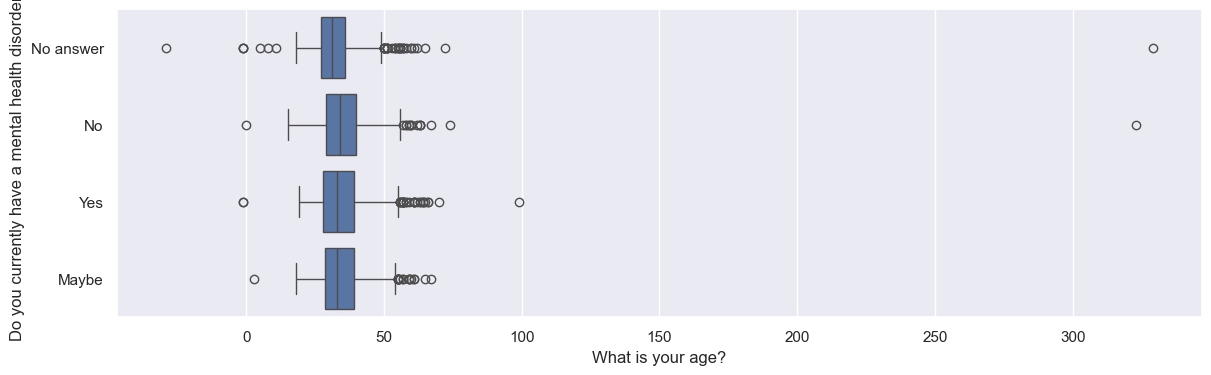

In [57]:
sns.boxplot(data=df_all,x='What is your age?', y='Do you currently have a mental health disorder?')

There are anomalies seen in the boxplot: negative, around zero, 99 and greater ages. Let's build another boxplot without these anomalies.

Boxplot without the anomalies

<Axes: xlabel='What is your age?', ylabel='Do you currently have a mental health disorder?'>

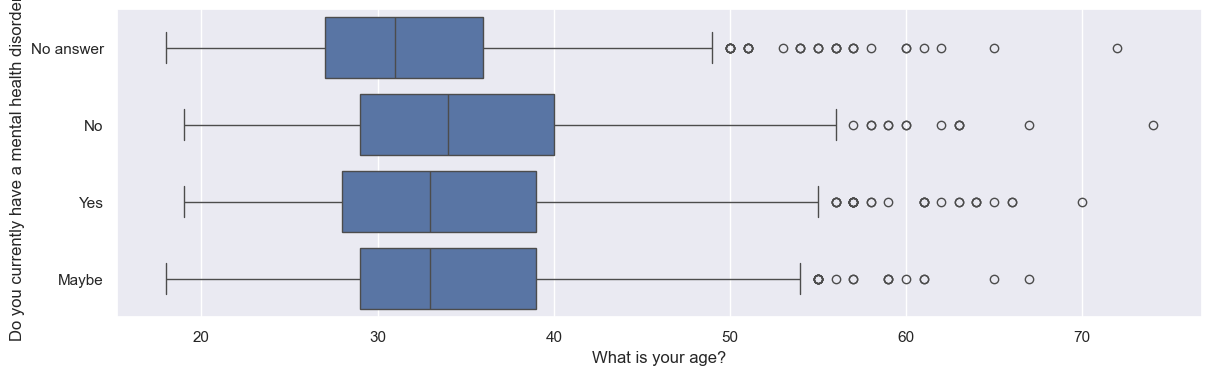

In [58]:
sns.boxplot(data=df_all[df_all['What is your age?'].between(18, 80)],x='What is your age?', y='Do you currently have a mental health disorder?')

In [59]:
df_all[df_all['What is your age?'].between(18, 80)].groupby(['What is your gender?'])['What is your age?'].mean()

What is your gender?
Female    33.561523
Male      34.085092
Other     31.273973
Name: What is your age?, dtype: float64

In [60]:
df_all[df_all['What is your age?'].between(18, 80)]['What is your age?'].mean()

np.float64(33.85982865302237)

- Age spread is similar for all answers on 'Do you currently have a mental health disorder?' question.
- An average age is 34.

### Are you self-employed? question

In [61]:
df_all['Are you self-employed?'].value_counts(dropna=False)

Are you self-employed?
0     3550
1      650
-1      18
Name: count, dtype: int64

In [62]:
df_all.replace({'Are you self-employed?': {'1': 'Yes', '0': 'No', '-1': 'No answer'}}, inplace=True)

In [63]:
# df_all['Are you self-employed?'] = df_all['Are you self-employed?'].map({'1': 'Yes', '0': 'No', '-1': 'No answer'})

<Axes: xlabel='Are you self-employed?', ylabel='count'>

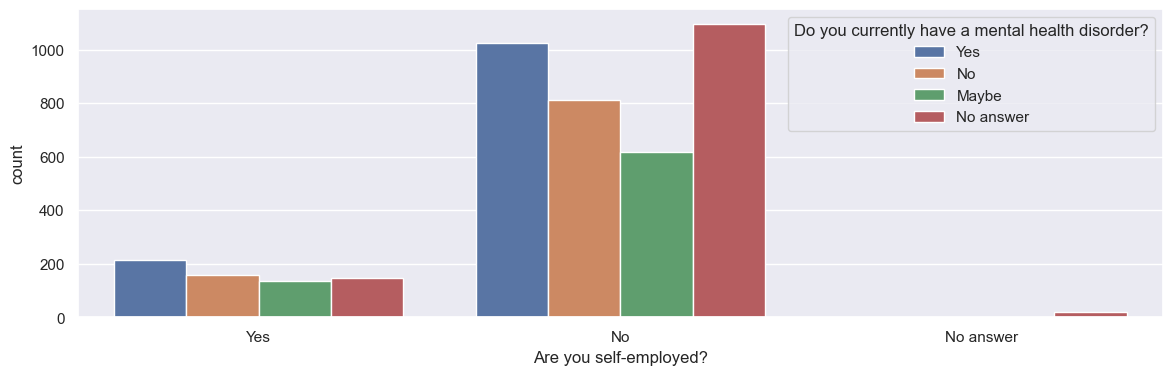

In [64]:
sns.countplot(df_all, x='Are you self-employed?', hue='Do you currently have a mental health disorder?',
             hue_order=['Yes', 'No', 'Maybe', 'No answer'], order=['Yes', 'No', 'No answer'] )

- Majority (3550 of 4218) of respondents answered that they are not self-employed.

### 'Do you have a family history of mental illness?' question

In [65]:
df_all['Do you have a family history of mental illness?'].value_counts(dropna=False)

Do you have a family history of mental illness?
Yes             1868
No              1701
I don't know     649
Name: count, dtype: int64

<Axes: xlabel='Do you have a family history of mental illness?', ylabel='count'>

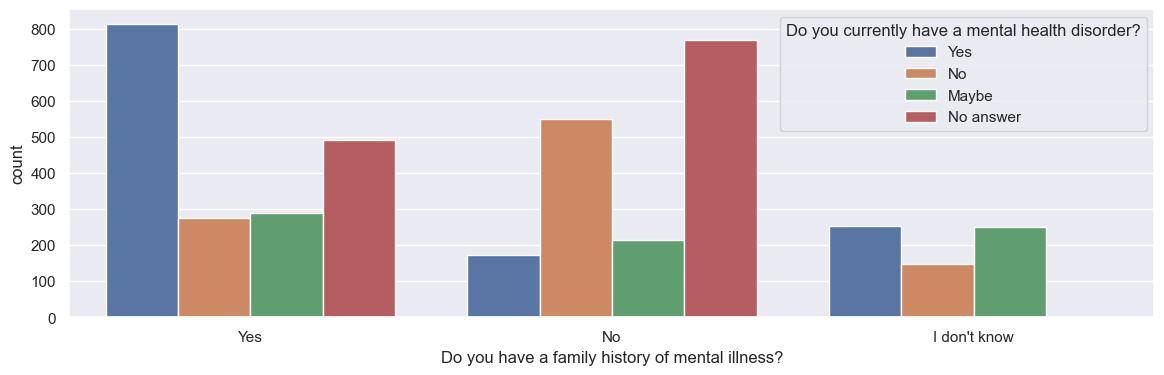

In [66]:
sns.countplot(df_all, x='Do you have a family history of mental illness?', hue='Do you currently have a mental health disorder?',
             hue_order=['Yes', 'No', 'Maybe', 'No answer'], order=['Yes', 'No', "I don't know"])

<Axes: xlabel='Do you currently have a mental health disorder?', ylabel='count'>

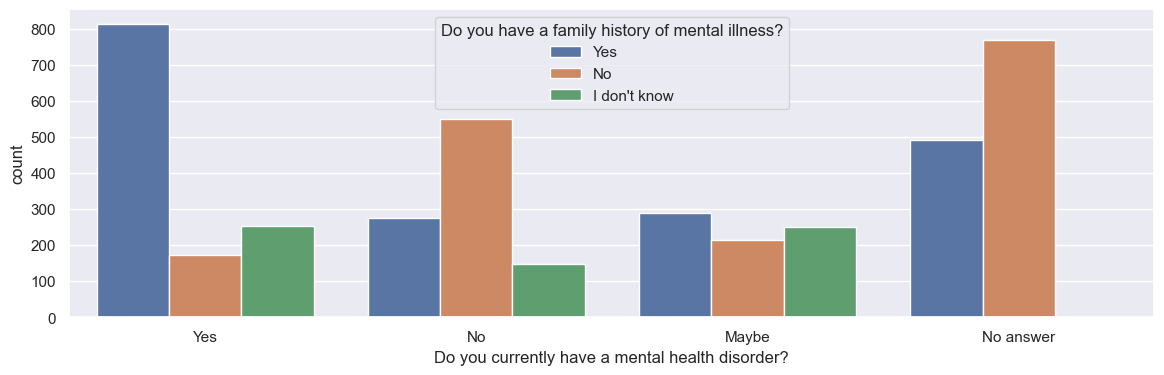

In [67]:
sns.countplot(df_all, hue='Do you have a family history of mental illness?', x='Do you currently have a mental health disorder?',
             order=['Yes', 'No', 'Maybe', 'No answer'], hue_order=['Yes', 'No', "I don't know"] )

- Question 'Do you have a family history of mental illness?' gathered almost equal number of 'Yes' and 'No' answers: 1868
and 1701 respectively. 
- Majority of respondents, who answered 'Yes' to 'Do you currently have a mental health disorder?' question provided the same answer for 'Do you have a family history of mental illness?' question; and 4 times numbers received answer 'No' for the second question.

Respondents who have mental disorders in their family history tends to have mental ilness also.

### 'Do you work remotely?' question

In [68]:
df_all['Do you work remotely?'].value_counts()

Do you work remotely?
Sometimes    757
Always       343
Never        333
Name: count, dtype: int64

<Axes: xlabel='Do you currently have a mental health disorder?', ylabel='count'>

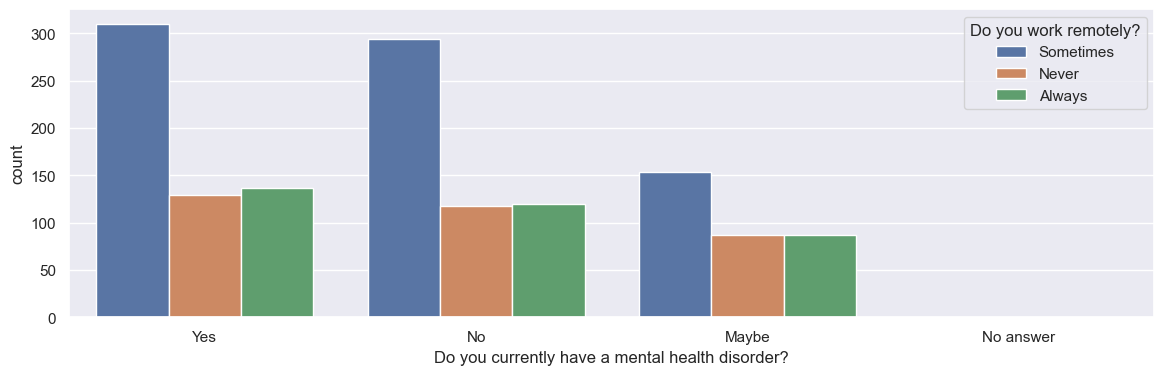

In [69]:
sns.countplot(df_all, hue='Do you work remotely?', x='Do you currently have a mental health disorder?',
             order=['Yes', 'No', 'Maybe', 'No answer'] )

- Question 'Do you work remotely?' has similar distribution for all answer options to 'Do you currently have a mental health disorder?' question.

### 'Does your employer provide mental health benefits as part of healthcare coverage?' question

In [70]:
df_all['Does your employer provide mental health benefits as part of healthcare coverage?'].value_counts(dropna=False)

Does your employer provide mental health benefits as part of healthcare coverage?
Yes                               1744
No                                 756
I don't know                       658
-1                                 504
Don't know                         408
Not eligible for coverage / NA     148
Name: count, dtype: int64

In [71]:
df_all.replace({'Does your employer provide mental health benefits as part of healthcare coverage?': 
                {"I don't know":"Don't know", '-1':'No answer'}}, inplace=True)

<Axes: xlabel='Does your employer provide mental health benefits as part of healthcare coverage?', ylabel='count'>

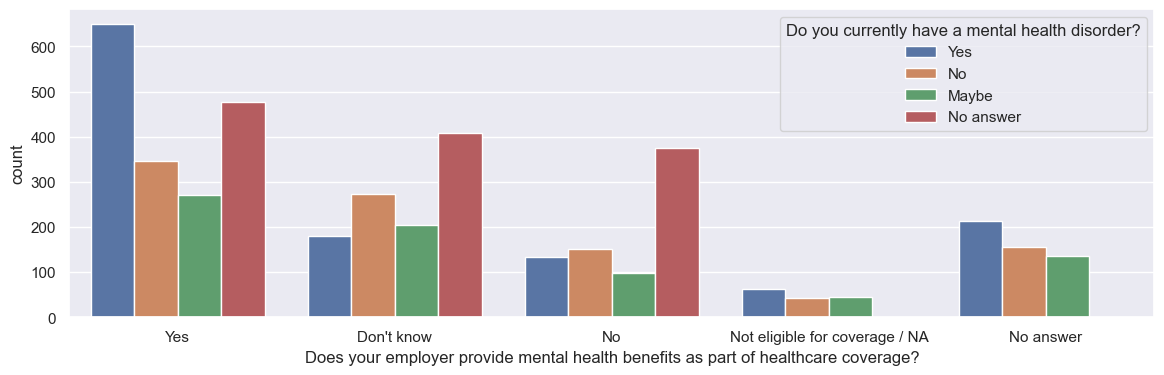

In [72]:
sns.countplot(df_all, x='Does your employer provide mental health benefits as part of healthcare coverage?', 
              hue='Do you currently have a mental health disorder?',
             hue_order=['Yes', 'No', 'Maybe', 'No answer'] )

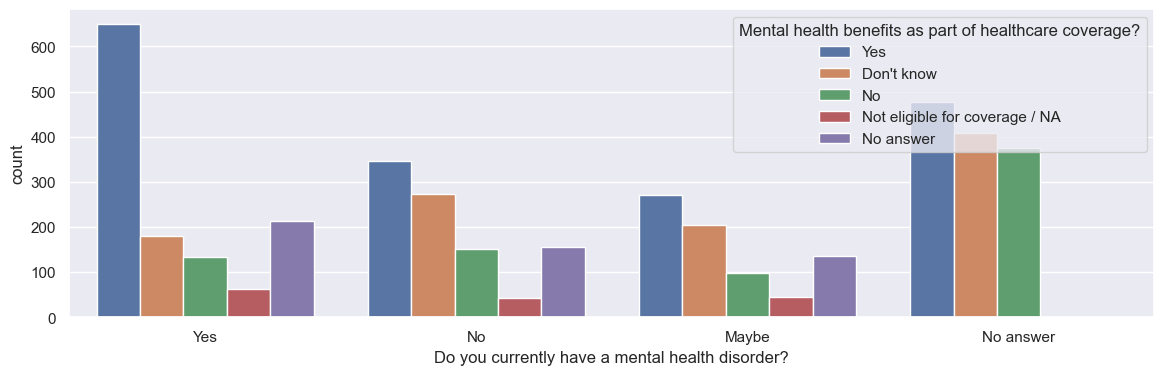

In [73]:
sns.countplot(df_all, hue='Does your employer provide mental health benefits as part of healthcare coverage?', 
              x='Do you currently have a mental health disorder?', order=['Yes', 'No', 'Maybe', 'No answer'] )
plt.legend(title='Mental health benefits as part of healthcare coverage?', loc='upper right')

In [74]:
df_all['Does your employer provide mental health benefits as part of healthcare coverage?']\
[df_all['Do you currently have a mental health disorder?']=='Yes'].value_counts()

Does your employer provide mental health benefits as part of healthcare coverage?
Yes                               650
No answer                         213
Don't know                        179
No                                133
Not eligible for coverage / NA     62
Name: count, dtype: int64

- There is a clear connection between 'Does your employer provide mental health benefits as part of healthcare coverage?' and 'Do you currently have a mental health disorder?' questions.
- There are 650 'Yes' vs 133 'No' for the question 'Does your employer provide mental health benefits as part of healthcare coverage?' question who agreed that they have mental health disorder.
- There is more chance that a person says that he/she has a mental health disorder if his/her employer provides mental health benefits as part of healthcare coverage or another point of view: a person with a mental health disorder tends to choose an employer that provides mental health benefits as part of healthcare coverage.

### 'What country do you live in?' question

In [75]:
df_all['What country do you live in?'].value_counts(dropna=False)[df_all['What country do you live in?'].value_counts()>=10]

What country do you live in?
United States of America    1853
United States                751
United Kingdom               482
Canada                       199
Germany                      136
Netherlands                   98
Australia                     73
Ireland                       51
France                        51
India                         50
Brazil                        37
Sweden                        29
Switzerland                   28
Spain                         26
New Zealand                   24
Portugal                      23
Poland                        21
Italy                         19
Belgium                       17
South Africa                  16
Russia                        16
Bulgaria                      13
Finland                       13
Norway                        12
Mexico                        12
Austria                       10
Name: count, dtype: int64

In [76]:
df_all['What country do you live in?'][df_all['What country do you live in?'].isin(['United States of America', 'United States'])] = 'USA'

C:\Users\Mahoni\AppData\Local\Temp\ipykernel_8168\2763152612.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_all['What country do you live in?'][df_all['What country do you live in?'].isin(['United States of America', 'United States']

In [77]:
other_countries = df_all['What country do you live in?'].value_counts(dropna=False)[df_all['What country do you live in?'].value_counts()<50].index.to_list()

In [78]:
len(other_countries)

71

In [79]:
df_all['country'] = df_all['What country do you live in?'].apply(lambda x: 'Other' if x in other_countries else x)

In [80]:
df_all['country'].value_counts()

country
USA               2604
United Kingdom     482
Other              474
Canada             199
Germany            136
Netherlands         98
Australia           73
France              51
Ireland             51
India               50
Name: count, dtype: int64

In [81]:
mhd_by_country = df_all.groupby(['country', 'Do you currently have a mental health disorder?'])['Do you currently have a mental health disorder?'].count()

In [82]:
mhd_by_country_perc = mhd_by_country / df_all['country'].value_counts()

In [83]:
mhd_by_country_perc = mhd_by_country_perc.to_frame()

In [84]:
mhd_by_country_perc.columns = ['percent']

In [85]:
mhd_by_country_perc

percent
country        Do you currently have a mental health disorder?          
Australia      Maybe                                            0.136986
               No                                               0.219178
               No answer                                        0.301370
               Yes                                              0.342466
Canada         Maybe                                            0.175879
               No                                               0.226131
               No answer                                        0.361809
               Yes                                              0.236181
France         Maybe                                            0.235294
               No                                               0.411765
               No answer                                        0.254902
               Yes                                              0.098039
Germany        Maybe                                            0.205882
               No                                               0.330882
               No answer                                        0.330882
               Yes                                              0.132353
India          Maybe                                            0.280000
               No                                               0.400000
               No answer                                        0.200000
               Yes                                              0.120000
Ireland        Maybe                                            0.039216
               No                                               0.274510
               No answer                                        0.529412
               Yes                                              0.156863
Netherlands    Maybe                                            0.142857
               No                                               0.295918
               No answer                                        0.275510
               Yes                                              0.285714
Other          Maybe                                            0.261603
               No                                               0.324895
               No answer                                        0.227848
               Yes                                              0.185654
USA            Maybe                                            0.164363
               No                                               0.198157
               No answer                                        0.288402
               Yes                                              0.349078
United Kingdom Maybe                                            0.176349
               No                                               0.226141
               No answer                                        0.383817
               Yes                                              0.213693

In [86]:
mhd_by_country_perc.reset_index(inplace=True)

##### mental health disorder=yes as percent for country in descending order.

In [87]:
mhd_by_country_perc[mhd_by_country_perc['Do you currently have a mental health disorder?']=='Yes'].sort_values(['percent'], ascending=False)

,country,Do you currently have a mental health disorder?,percent
35,USA,Yes,0.349078
3,Australia,Yes,0.342466
27,Netherlands,Yes,0.285714
7,Canada,Yes,0.236181
39,United Kingdom,Yes,0.213693
31,Other,Yes,0.185654
23,Ireland,Yes,0.156863
15,Germany,Yes,0.132353
19,India,Yes,0.120000
11,France,Yes,0.098039


##### mental health disorder=no as percent for country in descending order.

In [88]:
mhd_by_country_perc[mhd_by_country_perc['Do you currently have a mental health disorder?']=='No'].sort_values(['percent'], ascending=False)

,country,Do you currently have a mental health disorder?,percent
9,France,No,0.411765
17,India,No,0.400000
13,Germany,No,0.330882
29,Other,No,0.324895
25,Netherlands,No,0.295918
21,Ireland,No,0.274510
37,United Kingdom,No,0.226141
5,Canada,No,0.226131
1,Australia,No,0.219178
33,USA,No,0.198157


<Axes: xlabel='country', ylabel='percent'>

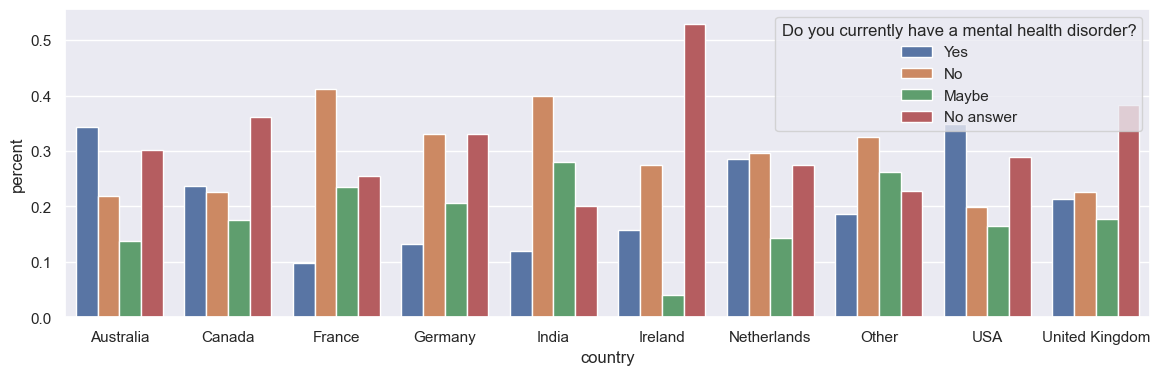

In [89]:
sns.barplot(data=mhd_by_country_perc, x='country', y='percent', hue='Do you currently have a mental health disorder?', 
            hue_order=['Yes', 'No', 'Maybe', 'No answer'])

<Axes: xlabel='Do you currently have a mental health disorder?', ylabel='percent'>

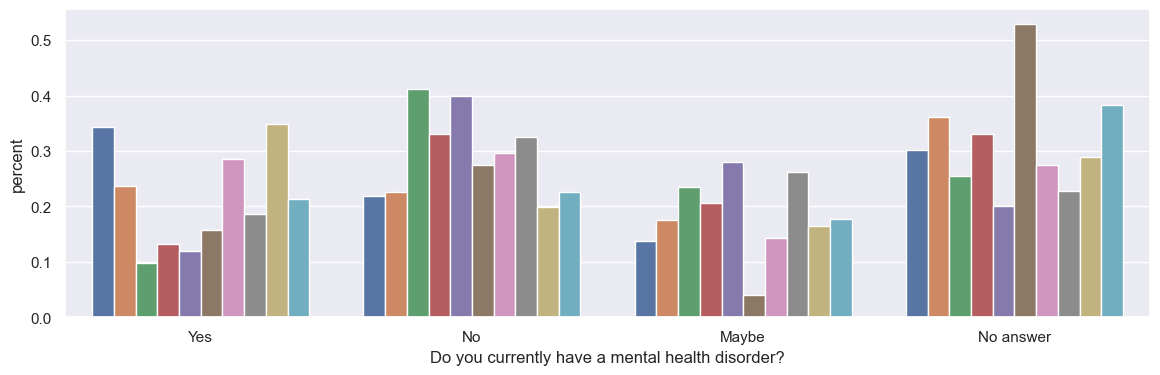

In [90]:
sns.barplot(data=mhd_by_country_perc, hue='country', y='percent', x='Do you currently have a mental health disorder?', 
            order=['Yes', 'No', 'Maybe', 'No answer'], legend=False)

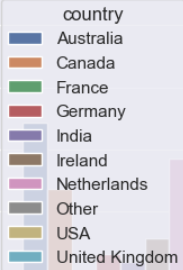

- The leader countries of 'Yes' answer to 'Do you currently have a mental health disorder?' (by percentage) question are: Australia, USA. France and India are at bottom of the list.
- The leader countries of 'No' answer are: France, India. Australia and USA are at the bottom of the list.

## Mental diseases

##### 'Do you currently have a mental health disorder?' and 'If yes, what condition(s) have you been diagnosed with?' questions connection

In [91]:
df_answer[(df_answer['r_id'].isin(df_answer['r_id'][df_answer['q_id']==33])) & (df_answer['q_id'] == 115)]['r_id'].nunique()

1433

In [92]:
df_answer['ans'][df_answer['q_id'] == 33].count()

np.int64(2958)

In [93]:
df_answer['r_id'][df_answer['q_id'] == 115].nunique()

1433

In [94]:
df_answer[df_answer['q_id'] == 115]['s_id'].value_counts()

s_id
2016    2072
Name: count, dtype: int64

Number of respondents who answered on 'Do you currently have a mental health disorder?' question: 2958

Number of respondents who answered on 'If yes, what condition(s) have you been diagnosed with?' question: 1433

Number of respondents who answered on both that questions: 1433

All respondents who answered on 'If yes, what condition(s) have you been diagnosed with?' question also answered on 'Do you currently have a mental health disorder?' question

It is found that answers for 'If yes, what condition(s) have you been diagnosed with?' question received only in 2016.

It was shown before that answers for 'Do you currently have a mental health disorder?' question are similarly distributed throught the years with more answers received in 2016.

It is possible, that 'If yes, what condition(s) have you been diagnosed with?' question was asked only in 2016.

#### Top mental health disorders 

In [95]:
df_answer['ans'][df_answer['q_id'] == 115].value_counts()

ans
-1                                                                                                                                                           865
Mood Disorder (Depression, Bipolar Disorder, etc)                                                                                                            412
Anxiety Disorder (Generalized, Social, Phobia, etc)                                                                                                          345
Attention Deficit Hyperactivity Disorder                                                                                                                     121
Post-traumatic Stress Disorder                                                                                                                                69
Obsessive-Compulsive Disorder                                                                                                                                 45
Substance Use Disorder        

3 top mental health disorders:
- Mood Disorder (Depression, Bipolar Disorder, etc)                                                                                                            412
- Anxiety Disorder (Generalized, Social, Phobia, etc)                                                                                                          345
- Attention Deficit Hyperactivity Disorder                                                                                                                     121

## Prevalence rate of mental diseases

In [96]:
disorders = ['Mood Disorder (Depression, Bipolar Disorder, etc)', 'Anxiety Disorder (Generalized, Social, Phobia, etc)', 'Attention Deficit Hyperactivity Disorder']

In [97]:
resps_with_top_disorders = df_answer[['r_id', 'ans']][(df_answer['q_id']==115) & (df_answer['ans'].isin(disorders))]
df_top_disorders = pd.get_dummies(resps_with_top_disorders.set_index('r_id'), columns=['ans'], prefix='', prefix_sep='').groupby('r_id').sum()
df_all = df_all.merge(right=df_top_disorders, left_on='r_id', right_on='r_id', how='left')
df_all[disorders] = df_all[disorders].replace({1: 'Yes', 0: 'No'})
df_all[disorders] = df_all[disorders].fillna('No')

##### Calculation of number and percentage of respondents with top disorders

'Yes' tick put if a respondent mentioned a disorder in answering the question, 'No' - otherwise. 

So, all respondents have marks 'Yes' either 'No' for these top questions in this part of analysis (another strategy is applied in the following part).

In [98]:
for disorder in disorders:
    print(df_all.groupby(disorder)[disorder].count())

Mood Disorder (Depression, Bipolar Disorder, etc)
No     3806
Yes     412
Name: Mood Disorder (Depression, Bipolar Disorder, etc), dtype: int64
Anxiety Disorder (Generalized, Social, Phobia, etc)
No     3873
Yes     345
Name: Anxiety Disorder (Generalized, Social, Phobia, etc), dtype: int64
Attention Deficit Hyperactivity Disorder
No     4097
Yes     121
Name: Attention Deficit Hyperactivity Disorder, dtype: int64


In [99]:
for disorder in disorders:
    print(df_all.groupby(['What is your gender?', disorder])[disorder].count() * 100/ df_all.groupby(['What is your gender?'])[disorder].count())
    print(f"Prevalence rate of {disorder}: {df_answer['ans'][df_answer['q_id'] == 115].value_counts().loc[disorder]/df_all.shape[0]*100:.2f}%\n")

What is your gender?  Mood Disorder (Depression, Bipolar Disorder, etc)
Female                No                                                   85.742188
                      Yes                                                  14.257812
Male                  No                                                   92.044707
                      Yes                                                   7.955293
Other                 No                                                   84.210526
                      Yes                                                  15.789474
Name: Mood Disorder (Depression, Bipolar Disorder, etc), dtype: float64
Prevalence rate of Mood Disorder (Depression, Bipolar Disorder, etc): 9.77%

What is your gender?  Anxiety Disorder (Generalized, Social, Phobia, etc)
Female                No                                                     88.769531
                      Yes                                                    11.230469
Male                 

Prevalence rates:
- Mood Disorder (Depression, Bipolar Disorder, etc) is 10%, by gender: 14% of females, 16% of 'other' gender, 8% of males.
- Anxiety Disorder (Generalized, Social, Phobia, etc) is 8%, by gender: 11% of females and 'other' gender, 7% of males.
- Attention Deficit Hyperactivity Disorder is 3%, by gender: 4% of females, 3% of 'other' gender, 2% of males.

### Prevalence confidence interval

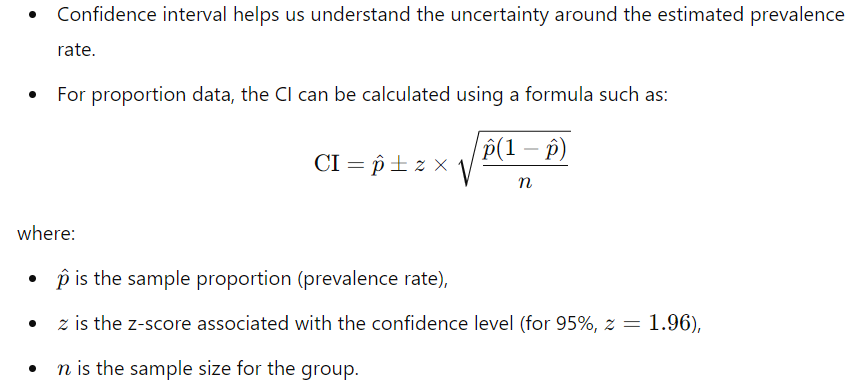

Confidence level of 95% is chosen, hence z=1.96

In [100]:
z = 1.96

In [101]:
df_total  = pd.DataFrame({'gender': ['Female', 'Male', 'Other'], 'total': [1024, 3042, 152]} , [1,2,3])

In [102]:
df_top_disorders = pd.DataFrame()
for i in range(3):
    df_temp = df_all.groupby(['What is your gender?', disorders[i]])[disorders[i]].count() * 100/ df_all.groupby(['What is your gender?'])[disorders[i]].count()
    # print(df_temp, '\n')
    df_temp = df_temp.to_frame()
    df_temp.columns = [disorders[i]+'_percent']
    
    df_temp.reset_index(inplace=True)
    df_temp.columns = ['gender', 'answer', disorders[i]+'_percent']
    df_temp = df_temp.merge(right=df_total, how='left', left_on='gender', right_on='gender')
    df_temp[disorders[i]+'_Standard Error'] = np.sqrt((df_temp[disorders[i]+'_percent'] / 100) * (1 - (df_temp[disorders[i]+'_percent'] / 100)) / df_temp['total'])
    df_temp[disorders[i]+'_CI'] = z * df_temp[disorders[i]+'_Standard Error'] * 100
    if df_top_disorders.empty:
        df_top_disorders = df_temp.copy()
    else:
        df_top_disorders = df_top_disorders.merge(right=df_temp, how='inner', left_on=['gender', 'answer'], right_on=['gender', 'answer'])

In [103]:
df_top_disorders.iloc[:,[0,1,2,5,6,9,10,13,11]]

,gender,answer,"Mood Disorder (Depression, Bipolar Disorder, etc)_percent","Mood Disorder (Depression, Bipolar Disorder, etc)_CI","Anxiety Disorder (Generalized, Social, Phobia, etc)_percent","Anxiety Disorder (Generalized, Social, Phobia, etc)_CI",Attention Deficit Hyperactivity Disorder_percent,Attention Deficit Hyperactivity Disorder_CI,total
0,Female,No,85.742188,2.141558,88.769531,1.933913,96.093750,1.186680,1024
1,Female,Yes,14.257812,2.141558,11.230469,1.933913,3.906250,1.186680,1024
2,Male,No,92.044707,0.961621,92.998028,0.906825,97.501644,0.554638,3042
3,Male,Yes,7.955293,0.961621,7.001972,0.906825,2.498356,0.554638,3042
4,Other,No,84.210526,5.796973,88.815789,5.010511,96.710526,2.835531,152
5,Other,Yes,15.789474,5.796973,11.184211,5.010511,3.289474,2.835531,152


##### Plotting prevelance rates with confidence intervals

Prevalence rates for top disorders for all survey years


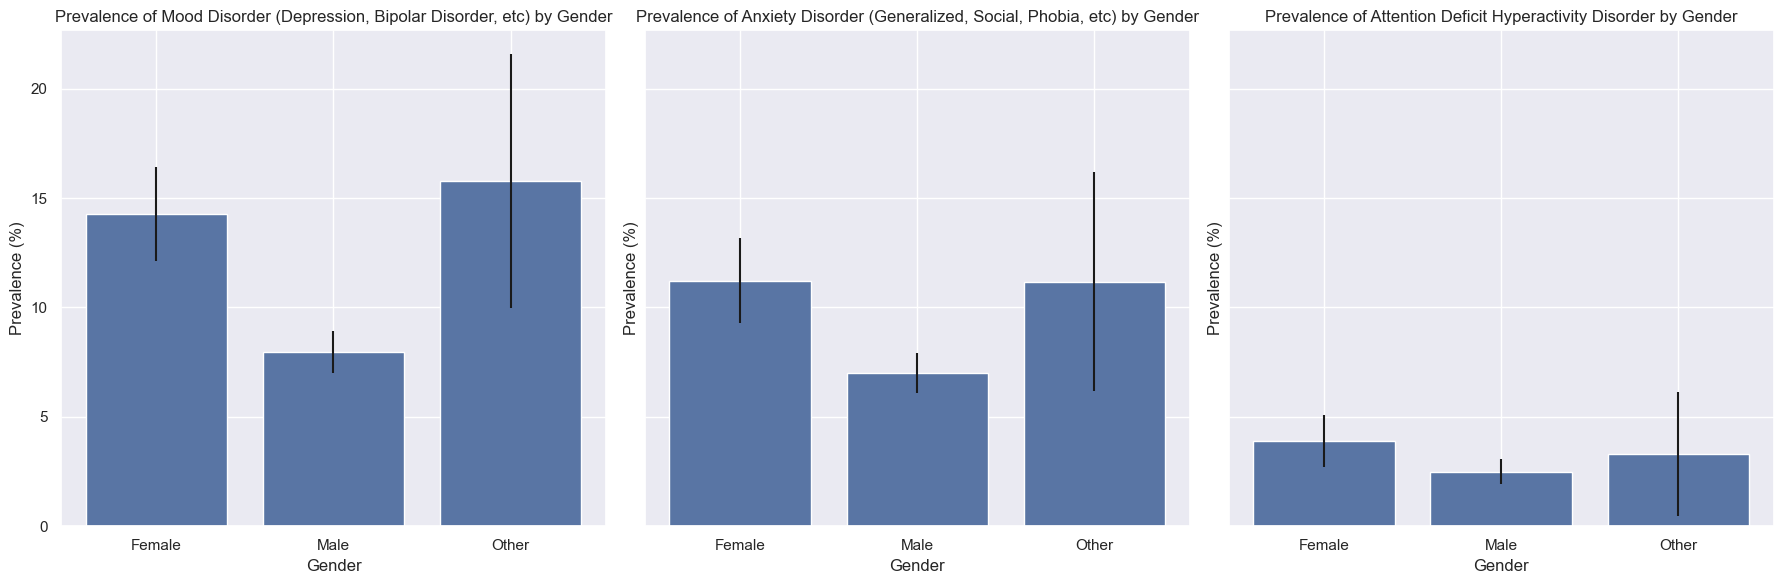

In [104]:
fig, axes = plt.subplots(1, len(disorders), figsize=(18, 6), sharey=True)
print('Prevalence rates for top disorders for all survey years')
for i, disorder in enumerate(disorders):
    try:
        sns.barplot(x='gender', y=disorder+'_percent', hue='answer', 
                    data=df_top_disorders[df_top_disorders['answer'] == 'Yes'],
                    yerr=df_top_disorders[df_top_disorders['answer'] == 'Yes'][disorder+'_CI'], 
                    ax=axes[i])

    except Exception as e:
        axes[i].set_title('Prevalence of ' + disorder + ' by Gender')
        axes[i].set_ylabel('Prevalence (%)')
        axes[i].set_xlabel('Gender')

plt.tight_layout()
plt.show()

#### Confidence intervals interpretation

The confidence intervals (CIs) provide a range of values that likely contain the true prevalence rate of the disorders in the population, with a specified level of confidence, typically 95%. In this case, the confidence intervals around the percentages represent the uncertainty or variability in the estimated prevalence rates of different mental health disorders by gender.

Here’s a more detailed interpretation:

- Prevalence: The estimated prevalence for females who answered "Yes" to having a mood disorder is 14.26%.
Confidence Interval: The 95% confidence interval is 14.26% ± 2.14%, meaning that the true prevalence in the female population likely falls between 12.12% and 16.40%.
Interpretation: We are 95% confident that the true prevalence of mood disorders in females lies within this interval. The interval reflects the uncertainty in our estimate, with a larger sample size typically yielding a narrower confidence interval.

Mood Disorder for Males:

- Prevalence: The prevalence for males is 7.96%.
Confidence Interval: The 95% CI is 7.96% ± 0.96%, meaning the true prevalence is between 6.99% and 8.92%.
Interpretation: This interval is narrower than the one for females, likely because the sample size for males is larger (3042 vs. 1024 for females). This suggests we have more precise estimates for the male population.

Attention Deficit Hyperactivity Disorder (ADHD) for Other Genders:

- Prevalence: The prevalence of ADHD in those identifying as "Other" is 3.29%.
Confidence Interval: The 95% CI is 3.29% ± 2.84%, meaning the true prevalence is between 0.45% and 6.12%.
Interpretation: This confidence interval is quite wide, likely because of the small sample size for this group (152 individuals). A smaller sample size increases uncertainty, resulting in a larger range of possible values for the true prevalence rate.

## Prevalence rate of mental diseases for 2016 year survey

Let's narrow respondents for the analysis as answers for 'If yes, what condition(s) have you been diagnosed with?' question present only for 2016 survey

In [105]:
df_answer['r_id'][df_answer['q_id']==115]

230341    1261
230342    1262
230343    1262
230344    1263
230345    1264
          ... 
232408    2692
232409    2693
232410    2693
232411    2693
232412    2693
Name: r_id, Length: 2072, dtype: int64

Respondent's ids who answered on 'If yes, what condition(s) have you been diagnosed with?' question are between 1261 and 2693.

Let's keep only these ids to calculate prevalence rates

In [106]:
resps_with_top_disorders = df_answer[['r_id', 'ans']][(df_answer['q_id']==115) & (df_answer['ans'].isin(disorders))]
df_top_disorders = pd.get_dummies(resps_with_top_disorders.set_index('r_id'), columns=['ans'], prefix='', prefix_sep='').groupby('r_id').sum()
df_all2 = df_all.iloc[1260: 2693,:].merge(right=df_top_disorders, left_on='r_id', right_on='r_id', how='left')
df_all2[disorders] = df_all[disorders].replace({1: 'Yes', 0: 'No'})
df_all2[disorders] = df_all[disorders].fillna('No')

In [107]:
for disorder in disorders:
    print(df_all2.groupby(disorder)[disorder].count())

Mood Disorder (Depression, Bipolar Disorder, etc)
No     1021
Yes     412
Name: Mood Disorder (Depression, Bipolar Disorder, etc), dtype: int64
Anxiety Disorder (Generalized, Social, Phobia, etc)
No     1088
Yes     345
Name: Anxiety Disorder (Generalized, Social, Phobia, etc), dtype: int64
Attention Deficit Hyperactivity Disorder
No     1312
Yes     121
Name: Attention Deficit Hyperactivity Disorder, dtype: int64


In [108]:
print('Prevalence rate of mental diseases for 2016 year survey')
for disorder in disorders:
    print(df_all2.groupby(['What is your gender?', disorder])[disorder].count() * 100/ df_all2.groupby(['What is your gender?'])[disorder].count())
    print(f"Prevalence rate of {disorder}: {df_answer['ans'][df_answer['q_id'] == 115].value_counts().loc[disorder]/df_all2.shape[0]*100:.2f}%\n")

Prevalence rate of mental diseases for 2016 year survey
What is your gender?  Mood Disorder (Depression, Bipolar Disorder, etc)
Female                No                                                   56.547619
                      Yes                                                  43.452381
Male                  No                                                   77.105014
                      Yes                                                  22.894986
Other                 No                                                   40.000000
                      Yes                                                  60.000000
Name: Mood Disorder (Depression, Bipolar Disorder, etc), dtype: float64
Prevalence rate of Mood Disorder (Depression, Bipolar Disorder, etc): 28.75%

What is your gender?  Anxiety Disorder (Generalized, Social, Phobia, etc)
Female                No                                                     65.773810
                      Yes                          

Prevalence rates for 2016 survey:
- Mood Disorder (Depression, Bipolar Disorder, etc) is 29%, by gender: 43% of females, 60% of 'other' gender, 23% of males.
- Anxiety Disorder (Generalized, Social, Phobia, etc) is 24%, by gender: 34% of females, 43% of 'other' gender, 20% of males.
- Attention Deficit Hyperactivity Disorder is 8%, by gender: 12% of females, 13% of 'other' gender, 7% of males.

### Prevalence rate confidence interval for 2016 survey

Defining short sample size

In [109]:
df_all.iloc[1260: 2693,:]['What is your gender?'].value_counts()

What is your gender?
Male      1057
Female     336
Other       40
Name: count, dtype: int64

In [110]:
z = 1.96

In [111]:
df_total2  = pd.DataFrame({'gender': ['Female', 'Male', 'Other'], 'total': [336, 1057, 40]} , [1,2,3])

In [112]:
df_top_disorders2 = pd.DataFrame()
for i in range(3):
    df_temp = df_all2.groupby(['What is your gender?', disorders[i]])[disorders[i]].count() * 100/ df_all2.groupby(['What is your gender?'])[disorders[i]].count()
    # print(df_temp, '\n')
    df_temp = df_temp.to_frame()
    df_temp.columns = [disorders[i]+'_percent']
    
    df_temp.reset_index(inplace=True)
    df_temp.columns = ['gender', 'answer', disorders[i]+'_percent']
    df_temp = df_temp.merge(right=df_total, how='left', left_on='gender', right_on='gender')
    df_temp[disorders[i]+'_Standard Error'] = np.sqrt((df_temp[disorders[i]+'_percent'] / 100) * (1 - (df_temp[disorders[i]+'_percent'] / 100)) / df_temp['total'])
    df_temp[disorders[i]+'_CI'] = z * df_temp[disorders[i]+'_Standard Error'] * 100
    if df_top_disorders2.empty:
        df_top_disorders2 = df_temp.copy()
    else:
        df_top_disorders2 = df_top_disorders2.merge(right=df_temp, how='inner', left_on=['gender', 'answer'], right_on=['gender', 'answer'])

In [113]:
df_top_disorders2.iloc[:,[0,1,2,5,6,9,10,13,11]]

,gender,answer,"Mood Disorder (Depression, Bipolar Disorder, etc)_percent","Mood Disorder (Depression, Bipolar Disorder, etc)_CI","Anxiety Disorder (Generalized, Social, Phobia, etc)_percent","Anxiety Disorder (Generalized, Social, Phobia, etc)_CI",Attention Deficit Hyperactivity Disorder_percent,Attention Deficit Hyperactivity Disorder_CI,total
0,Female,No,56.547619,3.036128,65.773810,2.906109,88.095238,1.983548,1024
1,Female,Yes,43.452381,3.036128,34.226190,2.906109,11.904762,1.983548,1024
2,Male,No,77.105014,1.493097,79.848628,1.425485,92.809839,0.918000,3042
3,Male,Yes,22.894986,1.493097,20.151372,1.425485,7.190161,0.918000,3042
4,Other,No,40.000000,7.788250,57.500000,7.858916,87.500000,5.257670,152
5,Other,Yes,60.000000,7.788250,42.500000,7.858916,12.500000,5.257670,152


##### Plotting prevalence rates with confidence interval of mental diseases for 2016 year survey

Prevalence rates for top disorders for 2016 survey


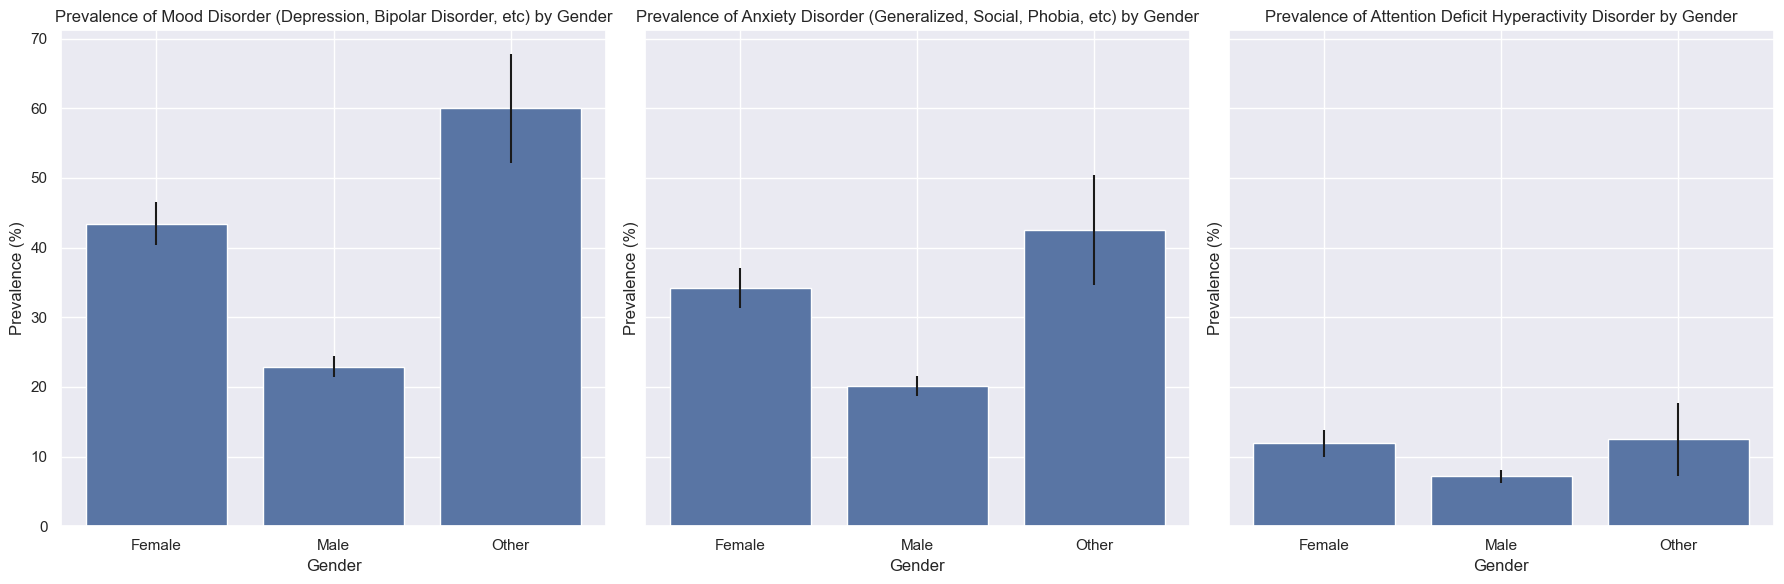

In [114]:
fig, axes = plt.subplots(1, len(disorders), figsize=(18, 6), sharey=True)
print('Prevalence rates for top disorders for 2016 survey')
for i, disorder in enumerate(disorders):
    try:
        sns.barplot(x='gender', y=disorder+'_percent', hue='answer', 
                    data=df_top_disorders2[df_top_disorders2['answer'] == 'Yes'],
                    yerr=df_top_disorders2[df_top_disorders2['answer'] == 'Yes'][disorder+'_CI'], 
                    ax=axes[i])

    except Exception as e:
        axes[i].set_title('Prevalence of ' + disorder + ' by Gender')
        axes[i].set_ylabel('Prevalence (%)')
        axes[i].set_xlabel('Gender')

plt.tight_layout()
plt.show()

### Bias 

Give an overview of the respondents of the survey.
- What is the sample size?
- What are the sociodemographic features of the respondents?
- Do you see any evidence of sampling bias?

4218 Respondents in the sample.

Top 10 countries (the other countries mentioned as 'Other'):
- USA               2604
- United Kingdom     482
- Other              474
- Canada             199
- Germany            136
- Netherlands         98
- Australia           73
- France              51
- Ireland             51
- India               50

There are 4218 respondents answering on 105 questions.

- Majority of respondents are males: 3042 (72%).
- Average respondents age is 34, by the gender: 34 females and males, 31 'other' gender.
- Top countries: USA, United Kingdom, Canada, Germany
- Majority of respondents are white, 873, 21%. Next popular answer is 'Mixed': 35, less than 1%.
- Answers for 'If yes, what condition(s) have you been diagnosed with?' mental disorder question present only in 2016 survey.

Yes, l see evidence of sampling bias in the study: 
- A half of respondents are from the USA.
- 72% are males.
- 21% are white (next answer is less than 1%)
- Probably not all questions were asked in all survey years

Defining of the data sample and analysis of tech industry are needed to get more confident answer regarding possible sampling bias.

### Results

There are 236898 answers received for 105 questions from 4218 respondents in dataset.

Received numbers for 'Do you currently have a mental health disorder?' question:
- No answer    1260
- Yes          1237
- No            969
- Maybe         752

There are 101 genders mentioned (some of them are doubled by different spelling). Majority of respondents are males (3042), females (1024) and others (152).
- 52% of 'other' gender, 41% of females and 24% of males noted they have mental health disorder.
- Average age without obvious outliers is similar for females and males (34 years) and a bit lower for other genders (31 years).
- distribution by age is similar for all answers to question about mental health disorder.

- 153 of 183 who answered 'Yes' to 'Are you openly identified at work as a person with a mental health issue?' question answered that they have mental disorder.
- interesting, that 7 respondents who answered that they are openly identified a a person with a mental health issue at work meantime claim they currently haven't mental health disorder.
- Majority of respondents who answered 'Yes' to "Do you currently have a mental health disorder?" question reported that they are not openly identified at work as person with a mental health issue: 507 vs 153.
- People tends not to spread information about their mental health disorder at work.

- Majority (3550 of 4218) of respondents answered that they are not self-employed.

- Question 'Do you work remotely?' has similar distribution for all answer options to 'Do you currently have a mental health disorder?' question.

Do you work remotely? question:
- Sometimes    757
- Always       343
- Never        333

- There is a clear connection between 'Does your employer provide mental health benefits as part of healthcare coverage?' and 'Do you currently have a mental health disorder?' questions.
- There are 650 'Yes' vs 133 'No' for the question 'Does your employer provide mental health benefits as part of healthcare coverage?' question who agreed that they have mental health disorder.
- There is more chance that a person says that he/she has a mental health disorder if his/her employer provides mental health benefits as part of healthcare coverage or another point of view: a person with a mental health disorder tends to choose an employer that provides mental health benefits as part of healthcare coverage.

- The leader countries of 'Yes' answer to 'Do you currently have a mental health disorder?' (by percentage) question are: Australia (35% claimed they have mental health disorder), USA (34%).
- France and India are at bottom of the list.
- The leader countries of 'No' answer are: France, India. Australia and USA are at the bottom of the list.
- So respondents from Australia and USA have greater chance to have mental health disorder and France, India have the lowest chance according to the respondent's answers.

Answers for 'If yes, what condition(s) have you been diagnosed with?' mental disorder question present only in 2016 survey.

### Conclusion

The greater chance to have a mental health disorder for respondent if he/she/they are not female nor male (other gender) from Australia or USA having a family history of mental illness and working for the company that provides mental health benefits as part of healthcare coverage.

The least chance to have a mental health disorder for respondent if he/she/they are male from France or India having no family history of mental illness and working for the company that provides no mental health benefits as part of healthcare coverage.

##### Prevalence rates of 3 top mental health disorders for all survey years

Mood Disorder (Depression, Bipolar Disorder, etc)
- 10% (412 of 4218 respondents)
- 14% of females
- 16% of 'other' gender
- 8% of males

Anxiety Disorder (Generalized, Social, Phobia, etc)
- 8% (345 of 4218 respondents)
- 11% of females
- 11% 'other' gender
- 7% of males

Attention Deficit Hyperactivity Disorder
- 3% (121 of 4218 respondents)
- 4% of females
- 3% 'other' gender
- 2% of males

##### Prevalence rates of 3 top mental health disorders in 2016

Mood Disorder (Depression, Bipolar Disorder, etc)
- 29%
- 43% of females
- 60% of 'other' gender
- 23% of males

Anxiety Disorder (Generalized, Social, Phobia, etc)
- 24%
- 34% of females
- 43% 'other' gender
- 20% of males

Attention Deficit Hyperactivity Disorder
- 8%
- 12% of females
- 13% 'other' gender
- 7% of males

Prevalence rates of 3 top mental health disorders are 3 times higher in 2016 than for all survey years as the corresponding answers were received only in 2016.

There is no additional information why some answers present only in one year survey.